In [4]:


import os
import random
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 1. 安装 Kaggle 库
!pip install -q kaggle

# 2. 上传你刚下载的 kaggle.json 文件
from google.colab import files
files.upload()  # 这会弹出文件选择框，请选择你的 kaggle.json 文件

# 3. 创建 ~/.kaggle 目录并将 json 文件移动过去
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# 4. 设置适当的权限（Kaggle API 要求）
!chmod 600 ~/.kaggle/kaggle.json

# 5. 验证安装（可选），列出你的账户信息
!kaggle config view

Saving kaggle.json to kaggle.json
Configuration values from /root/.kaggle
- username: mike0709
- path: None
- proxy: None
- competition: None


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("landlord/handwriting-recognition")

print("Path to dataset files:", path)

100%|██████████| 1.26G/1.26G [00:25<00:00, 53.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1


In [7]:
!ls /root/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1


ls: cannot access '/root/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1': No such file or directory


In [8]:
DATA_SET = '/root/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1'
# DATA_SET = '/kaggle/input/handwriting-recognition'
train = pd.read_csv(f'{DATA_SET}/written_name_train_v2.csv')
valid = pd.read_csv(f'{DATA_SET}/written_name_validation_v2.csv')
test = pd.read_csv(f'{DATA_SET}/written_name_test_v2.csv')

In [9]:
num_rows_to_drop = int((len(train)* 0.97))
train = train.drop(train.index[0:num_rows_to_drop])
num_rows_to_drop = int((len(valid)* 0.97))
valid = valid.drop(valid.index[0:num_rows_to_drop])

In [10]:
train.head()

,FILENAME,IDENTITY
321032,TRAIN_321033.jpg,NICOLAS
321033,TRAIN_321034.jpg,JADE
321034,TRAIN_321035.jpg,KPADE
321035,TRAIN_321036.jpg,BOIS
321036,TRAIN_321037.jpg,SARA


In [11]:
train.shape

(9929, 2)

In [12]:
valid.head()

,FILENAME,IDENTITY
40128,VALIDATION_40129.jpg,GRECET
40129,VALIDATION_40130.jpg,DE OLIVEIRA
40130,VALIDATION_40131.jpg,MARIE
40131,VALIDATION_40132.jpg,LUDIVINE
40132,VALIDATION_40133.jpg,MASSYL


In [13]:
valid.shape

(1242, 2)

In [14]:
print(f'{train.shape[0]} data in the training set')
print(f'{valid.shape[0]} data in the validation set')
print(f'{test.shape[0]} data in the test set')

9929 data in the training set
1242 data in the validation set
41370 data in the test set


In [15]:
train1 = pd.read_csv(f'{DATA_SET}/written_name_train_v2.csv')

In [16]:
list_1=list(train1.columns)
list_cate=[]
for i in list_1:
    print(i)
    if train1[i].dtype=='object':
        list_cate.append(i)


FILENAME
IDENTITY


In [17]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
for i in list_cate:
    train1[i]=encoder.fit_transform(train1[i])

In [18]:
train1

,FILENAME,IDENTITY
0,0,6790
1,1,88373
2,2,9411
3,3,54452
4,4,24870
...,...,...
330956,264052,59046
330957,264053,92820
330958,264054,23178
330959,264056,70125


In [19]:
X = train1.drop('FILENAME',axis=1)
y = train1['FILENAME']

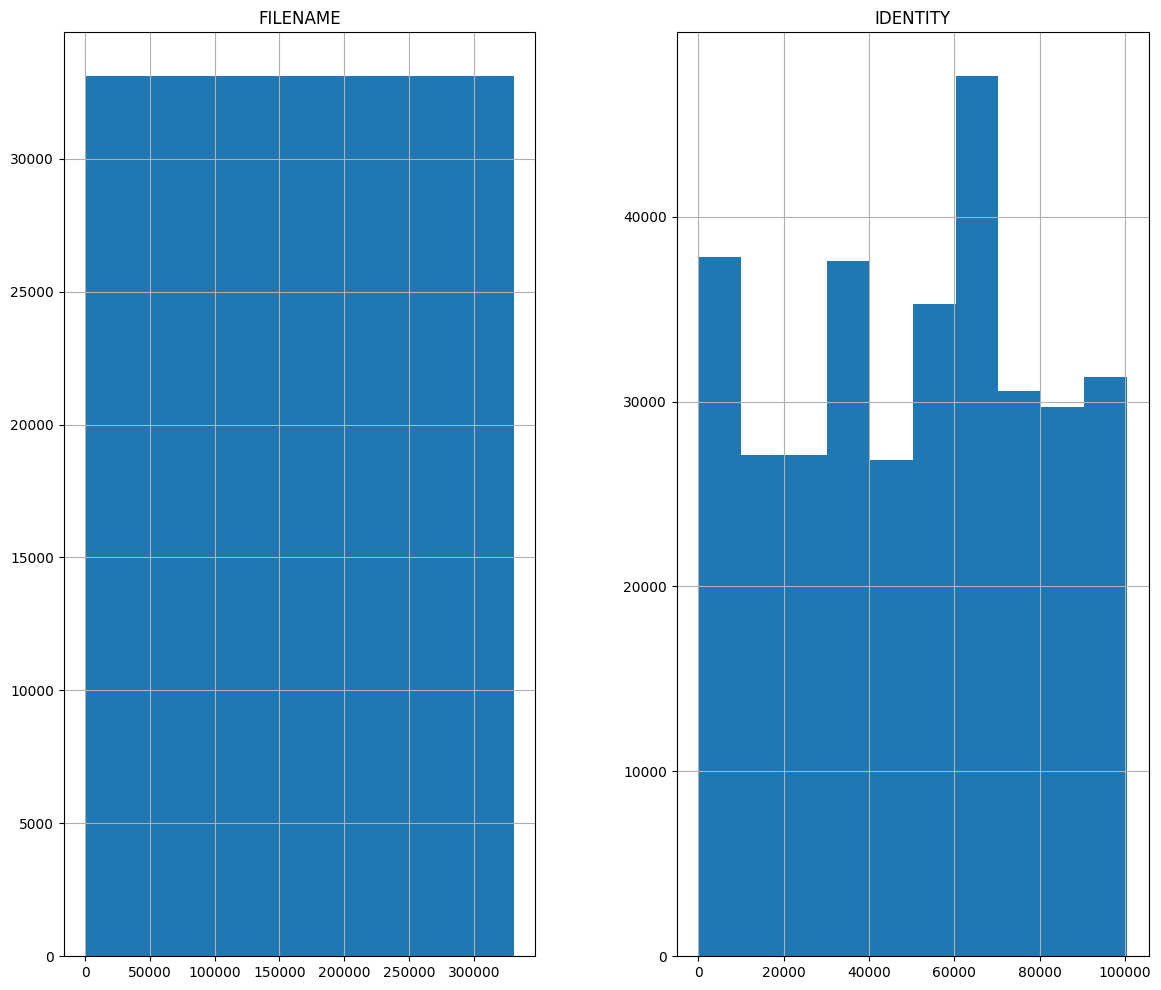

In [20]:
train1.hist(figsize=(14,12))
plt.show()

Text(0.5, 1.0, 'NICOLAS')

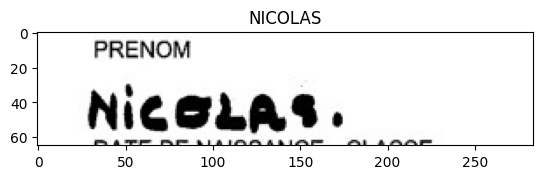

In [21]:
# Construct the file path correctly
img_filename = train.iloc[0, 0]  # Assuming first column contains filenames
img_dir = os.path.join(f'{DATA_SET}/train_v2/train', img_filename)

# Debugging: Check if the file exists
if not os.path.exists(img_dir):
    print(f"Error: File {img_dir} does not exist.")

image = Image.open(img_dir)

# Debugging: Check if the image was loaded correctly
if image is None:
    print(f"Error: Unable to read image {img_dir}")


plt.imshow(image, cmap='gray')
plt.title(train.iloc[0, 1], fontsize=12)  # Assuming second column has titles

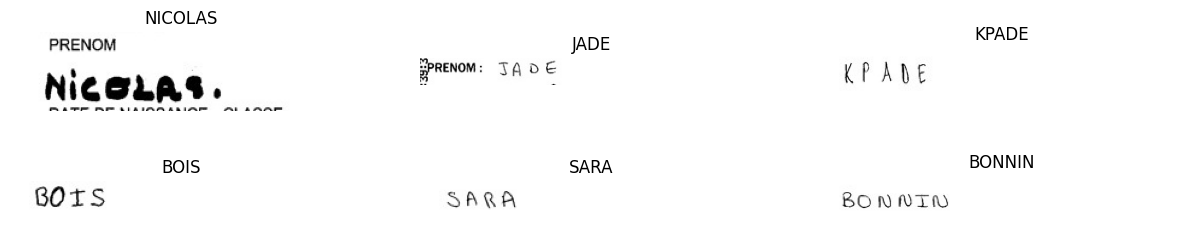

In [22]:
plt.figure(figsize=(15, 10))

# Check if train DataFrame is empty
if train.empty:
    print("Error: 'train' DataFrame is empty.")
else:
    # Iterate over the first 6 rows or until the end of the DataFrame, whichever comes first
    for i in range(min(6, len(train))):
        ax = plt.subplot(2, 3, i+1)

        # Construct the file path correctly
        img_filename = train.iloc[i, 0]  # Assuming first column contains filenames
        img_dir = os.path.join(f'{DATA_SET}/train_v2/train', img_filename)

        # Debugging: Check if the file exists
        if not os.path.exists(img_dir):
            print(f"Error: File {img_dir} does not exist.")
            continue

        image = Image.open(img_dir)

        # Debugging: Check if the image was loaded correctly
        if image is None:
            print(f"Error: Unable to read image {img_dir}")
            continue

        plt.imshow(image, cmap='gray')
        plt.title(train.iloc[i, 1], fontsize=12)  # Assuming second column has titles
        plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

**Data Cleaning**

In [23]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  17
Number of NaNs in validation set :  3


In [24]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

In [25]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


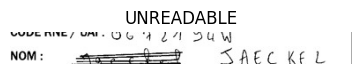

In [26]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace=True, drop=True)

plt.figure(figsize=(15, 10))

# Iterate over available rows in 'unreadable'
for i in range(min(unreadable.shape[0], 6)):
    ax = plt.subplot(2, 3, i+1)

    # Construct the correct image path
    img_filename = unreadable.loc[i, 'FILENAME']
    img_dir = os.path.join(f'{DATA_SET}/train_v2/train', img_filename)

    # Debugging: Check if file exists
    if not os.path.exists(img_dir):
        print(f"Error: File {img_dir} does not exist.")
        continue  # Skip this iteration

    # Read the image
    image = Image.open(img_dir)

    # Debugging: Check if image was read successfully
    if image is None:
        print(f"Error: Unable to read image {img_dir}")
        continue

    plt.imshow(image, cmap='gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

In [27]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']


In [28]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [29]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

## Data Preprocessing

In [64]:
from PIL import Image
import numpy as np

def preprocess(img):
    (h, w) = img.shape

    # 直接创建目标尺寸的数组
    final_img = np.ones([64, 256]) * 255  # blank white image

    # 计算放置位置（居中或左上角）
    start_h = 0
    start_w = 0
    crop_h = min(h, 64)
    crop_w = min(w, 256)

    # 放入图像
    final_img[start_h:start_h + crop_h, start_w:start_w + crop_w] = img[:crop_h, :crop_w]
    final_img_pil = Image.fromarray(final_img)
    final_img_pil = final_img_pil.resize((64, 256))
    res = np.array(final_img_pil)

    return res

In [65]:
train_size = 300
valid_size= 30

In [66]:

train_x = []
for i in range(train_size):
    img_dir = f'{DATA_SET}/train_v2/train/' + train.loc[i, 'FILENAME']

    try:
        image = Image.open(img_dir)

        # 转换为灰度图（如果需要）
        if image.mode != 'L':
            image = image.convert('L')

        # 转换为numpy数组
        image_array = np.array(image)

        # 预处理
        processed_image = preprocess(image_array)
        processed_image = processed_image / 255.0  # 归一化

        train_x.append(processed_image)

    except Exception as e:
        print(f"Error loading image {img_dir}: {str(e)}")

In [67]:

valid_x = []
for i in range(valid_size):
    img_dir = f'{DATA_SET}/validation_v2/validation/' + valid.loc[i, 'FILENAME']

    try:
        image = Image.open(img_dir)

        # 转换为灰度图（如果需要）
        if image.mode != 'L':
            image = image.convert('L')

        # 转换为numpy数组
        image_array = np.array(image)

        # 预处理
        processed_image = preprocess(image_array)
        processed_image = processed_image / 255.0  # 归一化

        valid_x.append(processed_image)

    except Exception as e:
        print(f"Error loading image {img_dir}: {str(e)}")

In [68]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [69]:
train_x.shape

(300, 256, 64, 1)

## Preparing the labels for CTC Loss

In [30]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [31]:
print(alphabets)

ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 


In [32]:
name = 'MICHAEL'
num = label_to_num(name)
print(name)
print(num)
print(num_to_label(num))


MICHAEL
[12  8  2  7  0  4 11]
MICHAEL


In [33]:
IMG_H = 64
IMG_W = 256
BATCH_SIZE = 64
NUM_EPOCHS = 20
CHARS = alphabets
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(SAVE_DIR, exist_ok=True)
PRINT_EVERY = 10

In [34]:
os.path.join(SAVE_DIR, f"crnn_epoch{0}.pt")

'/content/drive/MyDrive/Colab Notebooks/crnn_epoch0.pt'

In [35]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import os

class OCRDataset(Dataset):
    def __init__(self, dataframe, base_dir, max_str_len, num_of_timestamps, label_to_num_fn, target_size=(64, 256), transform=None):
        """
        Args:
            dataframe: 包含FILENAME和IDENTITY的DataFrame
            base_dir: 图像文件的基础目录
            max_str_len: 最大字符串长度
            num_of_timestamps: 时间戳数量
            label_to_num_fn: 标签转数字的函数
            target_size: 目标图像尺寸 (height, width)
            transform: 图像预处理变换
        """
        self.dataframe = dataframe.copy().reset_index(drop=True) # Create a copy to avoid in-place modification issues
        self.base_dir = base_dir
        self.max_str_len = max_str_len
        self.num_of_timestamps = num_of_timestamps
        self.label_to_num = label_to_num_fn
        self.target_size = target_size  # (height, width)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 获取图像路径和标签
        img_filename = self.dataframe.loc[idx, 'FILENAME']
        identity = str(self.dataframe.loc[idx, 'IDENTITY'])

        # 构建完整图像路径
        img_path = os.path.join(self.base_dir, img_filename)

        # 加载图像
        try:
            image = Image.open(img_path)
            if image.mode != 'L':
                image = image.convert('L')  # 转换为灰度图
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # 返回空白图像作为fallback
            image = Image.new('L', (self.target_size[1], self.target_size[0]), color=255)

        # 应用预处理：调整尺寸到统一大小
        image = self.preprocess_image(image)

        # 应用变换
        if self.transform:
            image_tensor = self.transform(image)
        else:
            # 转换为tensor并归一化
            image_array = np.array(image)
            image_tensor = torch.from_numpy(image_array).float() / 255.0
            image_tensor = image_tensor.unsqueeze(0)  # 添加通道维度 [1, H, W]

        # 准备标签数据
        label_len = len(identity)
        label = torch.ones(self.max_str_len) * -1
        label_indices = self.label_to_num(identity)

        # Truncate label_indices if it's longer than max_str_len
        if len(label_indices) > self.max_str_len:
            label_indices = label_indices[:self.max_str_len]
            label_len = self.max_str_len # Update label length if truncated


        label[:len(label_indices)] = torch.tensor(label_indices)

        # 其他训练参数
        input_len = torch.tensor([self.num_of_timestamps - 2], dtype=torch.float32)

        return {
            'image': image_tensor,  # 形状: [1, 64, 256]
            'label': label.long(),
            'label_len': torch.tensor([label_len], dtype=torch.long),
            'input_len': input_len,
            'identity': identity,
            'index': idx
        }

    def preprocess_image(self, img):
        """预处理图像：调整到统一尺寸"""
        # 调整到目标尺寸 (width, height)
        img = img.resize((self.target_size[1], self.target_size[0]), Image.Resampling.LANCZOS)
        return img

def custom_collate_fn(batch):
    """自定义collate函数处理不同长度的数据"""
    images = torch.stack([item['image'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    label_lens = torch.cat([item['label_len'] for item in batch])
    input_lens = torch.cat([item['input_len'] for item in batch])
    identities = [item['identity'] for item in batch]
    indices = torch.tensor([item['index'] for item in batch])

    # 检查图像维度是否正确
    # print(f"Batch images shape: {images.shape}")  # 应该是 [B, 1, 64, 256]

    return {
        'images': images,      # 形状: [B, 1, 64, 256]
        'labels': labels,      # 形状: [B, max_str_len]
        'label_lens': label_lens,  # 形状: [B, 1]
        'input_lens': input_lens,  # 形状: [B, 1]
        'identities': identities,
        'indices': indices
    }

# 创建数据集实例
train_dataset = OCRDataset(
    dataframe=train,
    base_dir=f'{DATA_SET}/train_v2/train/',
    max_str_len=max_str_len,
    num_of_timestamps=num_of_timestamps,
    label_to_num_fn=label_to_num,
    target_size=(64, 256),  # 指定目标尺寸 (height, width)
    transform=None
)

valid_dataset = OCRDataset(
    dataframe=valid,
    base_dir=f'{DATA_SET}/validation_v2/validation/',
    max_str_len=max_str_len,
    num_of_timestamps=num_of_timestamps,
    label_to_num_fn=label_to_num,
    target_size=(64, 256),  # 指定目标尺寸 (height, width)
    transform=None
)

# 创建DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers=0  # 先设置为0避免多进程问题
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0
)

# 测试数据集
sample = train_dataset[100]
print('True label:', sample['identity'])
print('Label tensor:', sample['label'])
print('Label length:', sample['label_len'].item())
print('Input length:', sample['input_len'].item())
print('Image shape:', sample['image'].shape)  # 应该输出: torch.Size([1, 64, 256])

# 测试一个batch
test_batch = next(iter(train_loader))
print(f"Batch images shape: {test_batch['images'].shape}")  # 应该输出: torch.Size([32, 1, 64, 256])

True label: JULIEN
Label tensor: tensor([ 9, 20, 11,  8,  4, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1])
Label length: 6
Input length: 62.0
Image shape: torch.Size([1, 64, 256])
Batch images shape: torch.Size([64, 1, 64, 256])


In [36]:
class CRNN(nn.Module):
    def __init__(self, img_h=64, num_channels=1, num_classes=len(CHARS)+1, hidden_size=256):
        super().__init__()
        # 简化的CNN结构，使用自适应池化
        self.cnn = nn.Sequential(
            # 第一层：64->32
            nn.Conv2d(num_channels, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # 第二层：32->16
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # 第三层：16->8
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # 第四层：8->4
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # 自适应池化确保高度为1
            nn.AdaptiveAvgPool2d((1, None))
        )

        self.hidden_size = hidden_size
        self.rnn1 = nn.LSTM(512, hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # x: [B, 1, 64, 256]
        conv = self.cnn(x)   # [B, 512, 1, W']
        b, c, h, w = conv.size()
        # print(f"CNN output shape: {conv.shape}")  # 调试信息
        conv = conv.squeeze(2)  # [B, 512, W]
        conv = conv.permute(0, 2, 1)  # [B, W, 512]
        rnn_out, _ = self.rnn1(conv)
        rnn_out, _ = self.rnn2(rnn_out)
        logits = self.fc(rnn_out)  # [B, W, num_classes]
        return logits.log_softmax(dim=2)

In [37]:
# 确保字符集一致
CHARS = alphabets  # 或者 alphabets = CHARS
BLANK_IDX = len(CHARS)

# 创建索引映射
char2idx = {char: idx for idx, char in enumerate(CHARS)}
idx2char = {idx: char for idx, char in enumerate(CHARS)}

def greedy_ctc_decode(log_probs: torch.Tensor) -> List[str]:
    # log_probs: [B, T, C]
    preds = log_probs.argmax(dim=2).cpu().numpy()  # [B, T]
    results = []
    for seq in preds:
        prev = -1
        out = []
        for p in seq:
            if p != prev and p != BLANK_IDX:
                if p < len(CHARS):
                    out.append(idx2char[p])
            prev = p
        results.append("".join(out))
    return results

In [38]:
model = CRNN()
test_input = torch.randn(2, 1, 64, 256)
with torch.no_grad():
    output = model(test_input)
    print(f"Model output shape: {output.shape}")
    print(f"Model output shape: {greedy_ctc_decode(output)}")

Model output shape: torch.Size([2, 16, 30])
Model output shape: ['', 'B']


In [39]:
import csv
import os
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(train_loader, val_loader):
    model = CRNN().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    ctc_loss = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)

    log_path = os.path.join(SAVE_DIR, "training_log.csv")

    # 初始化日志文件
    with open(log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_acc", "val_error"])

    best_acc = 0.0

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_loss = 0.0
        count = 0

        for i, batch in enumerate(train_loader, 1):
            imgs = batch['images'].to(DEVICE)
            targets = batch['labels'].to(DEVICE)
            target_lengths = batch['label_lens'].squeeze(-1).to(DEVICE)

            log_probs = model(imgs)
            T = log_probs.size(1)
            input_lengths = torch.full(size=(log_probs.size(0),), fill_value=T, dtype=torch.long).to(DEVICE)

            optimizer.zero_grad()
            loss = ctc_loss(
                log_probs.permute(1, 0, 2),  # [T, B, C]
                targets,
                input_lengths,
                target_lengths
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            total_loss += loss.item()
            count += 1

            if i % PRINT_EVERY == 0:
                avg_loss = total_loss / count
                print(f"[Epoch {epoch}] Step {i}/{len(train_loader)} loss={avg_loss:.4f}")
                total_loss = 0.0
                count = 0

        # 验证阶段
        val_loss, val_acc = validate_and_save(model, val_loader, epoch, ctc_loss)
        val_error = 100 - val_acc

        # 记录日志
        with open(log_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, avg_loss, val_loss, val_acc, val_error])

        print(f"\n✅ Epoch {epoch} Summary:")
        print(f"Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Err: {val_error:.2f}%")

        # 保存最优模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_model.pt"))
            print(f"🔥 Best model updated (acc={best_acc:.2f}%)")


def validate_and_save(model, val_loader, epoch, ctc_loss):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    count = 0

    print(f"\n--- Epoch {epoch} Validation ---")

    with torch.no_grad():
        for val_batch in val_loader:
            imgs = val_batch['images'].to(DEVICE)
            targets = val_batch['labels'].to(DEVICE)
            target_lengths = val_batch['label_lens'].squeeze(-1).to(DEVICE)

            logp = model(imgs)
            T = logp.size(1)
            input_lengths = torch.full(size=(logp.size(0),), fill_value=T, dtype=torch.long).to(DEVICE)

            # 验证 loss
            loss = ctc_loss(logp.permute(1, 0, 2), targets, input_lengths, target_lengths)
            total_loss += loss.item()
            count += 1

            preds = greedy_ctc_decode(logp)
            identities = val_batch['identities']

            for true_label, pred_label in zip(identities, preds):
                total_correct += int(true_label == pred_label)
                total_samples += 1

    val_loss = total_loss / count
    val_acc = total_correct / total_samples * 100
    print(f"Validation Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}% ({total_correct}/{total_samples})")

    # 保存每个 epoch 模型
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"crnn_epoch{epoch}.pt"))

    return val_loss, val_acc


In [ ]:
train_model(train_loader, valid_loader)

[Epoch 1] Step 10/5161 loss=4.0247
[Epoch 1] Step 20/5161 loss=3.2132
[Epoch 1] Step 30/5161 loss=3.2044
[Epoch 1] Step 40/5161 loss=3.1665
[Epoch 1] Step 50/5161 loss=3.1658
[Epoch 1] Step 60/5161 loss=3.1840
[Epoch 1] Step 70/5161 loss=3.1134
[Epoch 1] Step 80/5161 loss=3.0948
[Epoch 1] Step 90/5161 loss=3.1212
[Epoch 1] Step 100/5161 loss=3.0830
[Epoch 1] Step 110/5161 loss=3.0681
[Epoch 1] Step 120/5161 loss=3.0252
[Epoch 1] Step 130/5161 loss=3.0610
[Epoch 1] Step 140/5161 loss=3.0010
[Epoch 1] Step 150/5161 loss=2.9706
[Epoch 1] Step 160/5161 loss=2.9935
[Epoch 1] Step 170/5161 loss=2.9361
[Epoch 1] Step 180/5161 loss=2.9386
[Epoch 1] Step 190/5161 loss=2.9381
[Epoch 1] Step 200/5161 loss=2.9266
[Epoch 1] Step 210/5161 loss=2.9242
[Epoch 1] Step 220/5161 loss=2.8909
[Epoch 1] Step 230/5161 loss=2.8866
[Epoch 1] Step 240/5161 loss=2.8630
[Epoch 1] Step 250/5161 loss=2.8422
[Epoch 1] Step 260/5161 loss=2.8600
[Epoch 1] Step 270/5161 loss=2.7772
[Epoch 1] Step 280/5161 loss=2.7257
[

In [40]:
# 加载模型
def load_complete_model(model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # 初始化模型（参数需要与保存时一致）
    model = CRNN()  # 使用保存时的相同参数

    # 加载状态字典
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)

    # 设置为评估模式
    model.eval()
    model.to(device)

    print(f"模型从 {model_path} 加载成功")
    return model

In [41]:
model = load_complete_model('/content/drive/MyDrive/Colab Notebooks/best_model.pt', device='cpu')

模型从 /content/drive/MyDrive/Colab Notebooks/best_model.pt 加载成功


In [48]:
def test_image_from_file(model, image_path):
    """测试新的图像文件"""
    model.eval()

    # 加载和预处理图像
    image = Image.open(image_path)
    if image.mode != 'L':
        image = image.convert('L')

    # 调整到模型期望的尺寸
    image = image.resize((256, 64), Image.Resampling.LANCZOS)  # (width, height)
    image_array = np.array(image)

    # 转换为tensor
    image_tensor = torch.from_numpy(image_array).float() / 255.0
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    image_tensor = image_tensor.to(DEVICE)

    with torch.no_grad():
        log_probs = model(image_tensor)
        pred = greedy_ctc_decode(log_probs)[0]

    # 显示结果
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"pred: '{pred}'")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # 显示所有时间步的预测
    pred_indices = log_probs.argmax(dim=2).cpu().numpy()[0]
    decoded_indices = []
    prev = -1
    for p in pred_indices:
        if p != prev and p != BLANK_IDX:
            if p < len(CHARS):
                decoded_indices.append(p)
        prev = p

    print(f"Original Outputs: {pred_indices}")
    print(f"Outputs after decoding: {decoded_indices}")
    print(f"Final predication: '{pred}'")

    plt.plot(pred_indices)
    plt.title('preds vs timestep')
    plt.xlabel('timestep')
    plt.ylabel('predicted char')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pred

Original Outputs: [ 9 29 29 29  4  4 10  4  8 11 29 29 29 29 29 24]
Outputs after decoding: [np.int64(9), np.int64(4), np.int64(10), np.int64(4), np.int64(8), np.int64(11), np.int64(24)]
Final predication: 'JEKEILY'


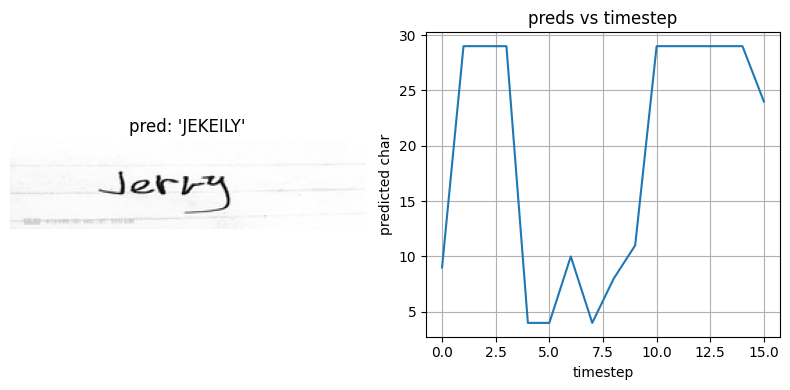

'JEKEILY'

In [58]:
idx = '0002'
image_path = f'{DATA_SET}/validation_v2/validation/VALIDATION_{idx}.jpg'
image_path = '/content/drive/MyDrive/Colab Notebooks/jerry.jpg'
# image_path = '/content/drive/MyDrive/Colab Notebooks/mike.jpg'

test_image_from_file(model, image_path=image_path)

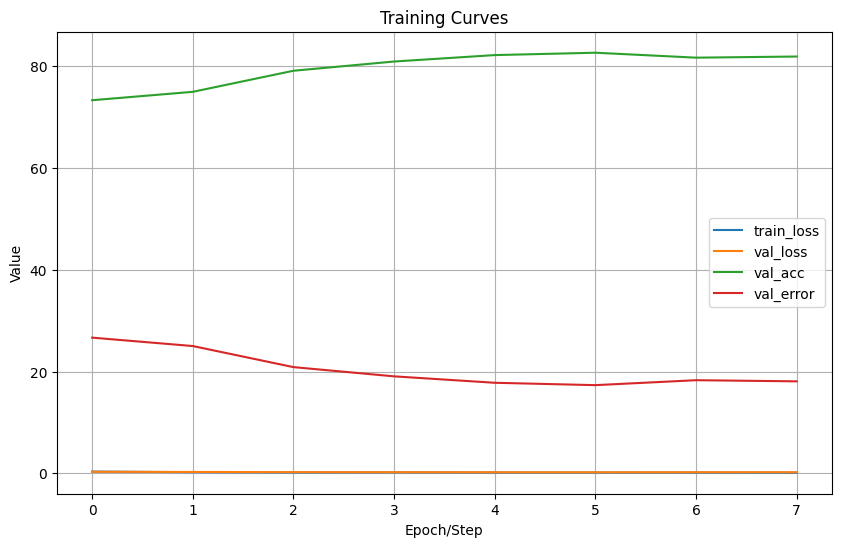

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

curve_path = '/content/drive/MyDrive/Colab Notebooks/training_log.csv'

# 读取数据
df = pd.read_csv(curve_path)

# 简单绘制所有数值列
plt.figure(figsize=(10, 6))

# 选择数值列（排除文本列）
numeric_columns = df.select_dtypes(include=['number']).columns

for col in numeric_columns:
    if col != 'epoch':
      plt.plot(df[col], label=col)

plt.title('Training Curves')
plt.xlabel('Epoch/Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()